######################################################################################################
# STAGE 3 - Analysis for 2 classes, title+content only
######################################################################################################


In [ ]:
# HOW TO IMPROVE MODELS?

### 1: (done in Notebook "Elisa_Report2_Modeling_Stage2")
# # try to improve prediction for left bottom corner (false negatives)
# PARAMETER TUNING (e.g. num_boost_rounds)
# --> improves results a lot


### 2: (done in Notebook "Elisa_Report2_Modeling_Stage2")
# use class_weights
# class 1: weight it 1,38 times
# done for logistic regression, passive aggressive classifier, SGD, LightGBM

# LogReg, PassiveAggressive, SGD: as attributes (class_weight=class_weights)

# LightGBM: in params 

# --> does not really improve results 
# --> test whether it changes in combination wih oversampling 



### 3: (done in Notebook "Elisa_Report2_Modeling_Stage2_randomoversample")
# --> using OverSample to deal with slightly unbalanced dataset
# Random Oversampling (RandomOverSampler) and SMOTE (SMOTE)
# not much of an improvement


### 4: DONE IN THIS NOTEBOOK
# Cross Validation (Stage 3)


### 5: DONE IN THIS NOTEBOOK
# compare different vectorizing methods



In [ ]:

##########################
## STAGE 3 - Analysis for 2 classes, title+content only
##########################

# USED PRE-PROCESSED DATASET: strats12_all_cleaned.pkl
# LOADING AS DF12
# --> contains 126.355  rows after pre-processing (2 classes)

# 0.0    73271
# 1.0    53084


# comparison of 3 different vectorization methods for some models (Count Vectorizer (Bag of Words), TF-IDF, word2vec)

## Pre-processing step:
# vectorize text (TF-IDF, CountVectorizer, word2vec)


# --> using stacking (combination of models with good performance from Stage 2)
# --> using Cross Validation to improve models
# --> interpret results

# We only used title + content (vectorized)


# MODELS FOR STAGE 3 (Optimized Models) - Chosen Models for final stage:
# 2) Naive Bayes Multinomial
# 4) Logistic Regression
# 6) Passive Aggressive Classifier
# 10) Stochastic Gradient Descent (SGD)


# Import libraries

In [149]:
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
# from sqlalchemy import create_engine
# import sqlalchemy as 
import sqlite3
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix 


# Load dataset + Pre-Processing

In [2]:
df12 = pd.read_pickle("strats12_all_cleaned.pkl")

In [150]:
df12.head(2)

,id,source,title,content,url,published_utc,label,factuality,questionable-source,conspiracy-pseudoscience,pro-science,content_cleaned
0,21stcenturywire--2022-04-26--An Unsettling Rea...,21stcenturywire,An Unsettling Realization: ‘Mask Zealots are S...,It’s been noted how the fanatical nature of ma...,https://21stcenturywire.com/2022/04/26/an-unse...,1650983484,1.0,2.0,0.0,1.0,0.0,It’s noted fanatical nature masking proponents...
1,21stcenturywire--2022-04-24--Episode #416 – ‘S...,21stcenturywire,Episode #416 – ‘Soldiers of Fortune’ with gues...,Episode #416 of SUNDAY WIRE SHOW resumes this ...,https://21stcenturywire.com/2022/04/24/episode...,1650823248,1.0,2.0,0.0,1.0,0.0,"Episode #416 SUNDAY WIRE SHOW resumes week, Ap..."


In [4]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170099 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        170099 non-null  object 
 1   source                    170099 non-null  object 
 2   title                     170099 non-null  object 
 3   content                   170099 non-null  object 
 4   url                       170099 non-null  object 
 5   published_utc             170099 non-null  int64  
 6   label                     170099 non-null  float64
 7   factuality                170099 non-null  float64
 8   questionable-source       170099 non-null  float64
 9   conspiracy-pseudoscience  170099 non-null  float64
 10  pro-science               170099 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 15.6+ MB


In [5]:
# inspect labels
df12["label"].value_counts()

# slightly unbalanced


0.0    73271
1.0    53084
2.0    43744
Name: label, dtype: int64

In [6]:
### DELETE 2 in labels (delete 43744 rows)
df12 = df12[df12["label"] != 2]


In [7]:
# inspect labels
df12["label"].value_counts()

# 0.0    73271
# 1.0    53084

0.0    73271
1.0    53084
Name: label, dtype: int64

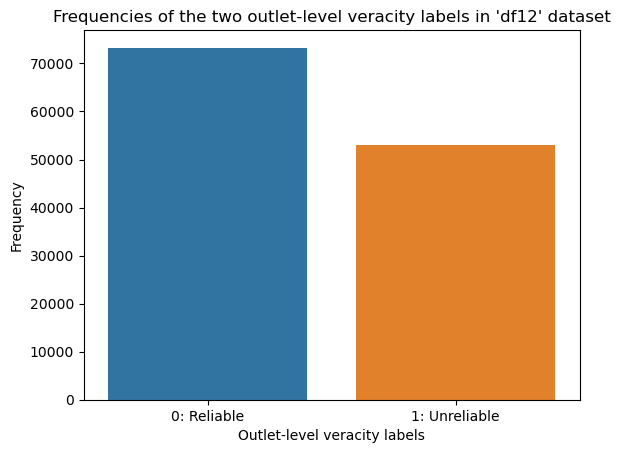

In [8]:
# barplot of labels
sns.countplot(x = "label", data = df12)
plt.xticks(np.arange(2),["0: Reliable", "1: Unreliable"])
plt.ylabel("Frequency")
plt.xlabel("Outlet-level veracity labels")
plt.title("Frequencies of the two outlet-level veracity labels in 'df12' dataset")
plt.show();


In [9]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   label                     126355 non-null  float64
 7   factuality                126355 non-null  float64
 8   questionable-source       126355 non-null  float64
 9   conspiracy-pseudoscience  126355 non-null  float64
 10  pro-science               126355 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.6+ MB


# Remove Stop Words 

In [10]:
import nltk
from nltk.corpus import stopwords

# Download stopwords corpus if not already downloaded
nltk.download('stopwords')

# Load the stopwords
stop_words = set(stopwords.words('english'))  # You can choose a different language if needed

# Update stop words variable
# stop_words.update([",", "."])

additional_words = ["?", "!", ".", ",", ":", ";", "-", "--", "...", '"', "'"]
stop_words.update(set(additional_words))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# show stop words
print(stop_words)


{'at', 'where', 'himself', "don't", 'through', 'couldn', 'both', '--', 'during', 'whom', 'is', 'while', "it's", 'have', 'all', 'before', 'be', "hadn't", 'into', 'few', "that'll", 'm', 'your', 'who', 'not', 'for', 'he', "wasn't", 'why', 'ours', "you'll", 'the', 'under', 'wouldn', 'if', 'now', 're', "didn't", 'had', 'such', 'same', 't', 'been', 'hers', 'shouldn', ':', 'that', 'most', 'than', 'of', 'having', 'this', 'so', 'no', 'then', "mightn't", 'and', 'are', 'y', "isn't", 'after', 'yourselves', 'each', 'hasn', 'what', 'they', "needn't", 'yourself', 'over', '.', 'themselves', 'between', "you've", 'him', 'd', 'shan', 'theirs', 'do', 'wasn', 'won', 'will', ',', 'up', 'with', 'by', 'about', "she's", 'haven', ';', 'them', '...', 'we', "couldn't", "mustn't", 'again', 'how', 'ourselves', 'an', 'weren', 'she', 'did', 'should', 'very', 'my', "shan't", 'it', 'itself', 'being', 'nor', 'some', 'has', 'hadn', 'more', 'you', '?', 've', 'her', 'their', "shouldn't", 'to', 'any', 'other', "won't", 'out

In [12]:
# content before removing stop words
df12["content"][:10]


0    It’s been noted how the fanatical nature of ma...
1    Episode #416 of SUNDAY WIRE SHOW resumes this ...
2    Authoritarians in the UK government are gettin...
3    After the 2020 election, many Americans began ...
4    The high stakes game surrounding the Ukraine c...
5    On the February 3, 2022 episode of Patrick Hen...
6    These are the darkest, most difficult days in ...
7    A shocking new trend is on the move in America...
8    In this episode of the Patrick Henningsen Show...
9    Liz Cheney invokes Ronald Reagan to bash those...
Name: content, dtype: object

In [13]:
# Apply
df12['content_cleaned'] = df12['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [14]:
df12["content_cleaned"][:10]


0    It’s noted fanatical nature masking proponents...
1    Episode #416 SUNDAY WIRE SHOW resumes week, Ap...
2    Authoritarians UK government getting increasin...
3    2020 election, many Americans began question m...
4    high stakes game surrounding Ukraine conflict ...
5    February 3, 2022 episode Patrick Henningsen Sh...
6    darkest, difficult days human history. facing ...
7    shocking new trend move America: following his...
8    episode Patrick Henningsen Show TNT Radio aire...
9    Liz Cheney invokes Ronald Reagan bash GOP want...
Name: content_cleaned, dtype: object

# Title + Content Data from df12 dataset

# Create X and Y (only title and text)
# X_train_text_df12_tfidf, 
# X_test_text_df12_tfidf, 
# Y_train_df12, 
# Y_test_df12 (uppercase letters)


In [15]:
# DEFINE X and Y
X_df12 = df12.drop("label", axis=1)
Y_df12 = df12["label"]


In [16]:
X_df12.columns = X_df12.columns.astype(str)

In [17]:
X_df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   factuality                126355 non-null  float64
 7   questionable-source       126355 non-null  float64
 8   conspiracy-pseudoscience  126355 non-null  float64
 9   pro-science               126355 non-null  float64
 10  content_cleaned           126355 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 11.6+ MB


In [18]:
X_df12.isnull().sum()

id                          0
source                      0
title                       0
content                     0
url                         0
published_utc               0
factuality                  0
questionable-source         0
conspiracy-pseudoscience    0
pro-science                 0
content_cleaned             0
dtype: int64

In [19]:
Y_df12.info()

<class 'pandas.core.series.Series'>
Int64Index: 126355 entries, 0 to 213392
Series name: label
Non-Null Count   Dtype  
--------------   -----  
126355 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [20]:
Y_df12.isnull().sum()

0

## Create Train / Test Datasets

In [21]:
from sklearn.model_selection import train_test_split

X_train_df12, X_test_df12, Y_train_df12, Y_test_df12 = train_test_split(X_df12, Y_df12, test_size=0.2)


# Vectorizing: TF-IDF VECTORIZER

### TFIDF Vectorizing
### USING CONTENT_CLEANED AND TITLE ONLY


In [22]:
# VECTORIZING
# TAKES 2 MINUTES

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

vectorizer1_df12_tfidf = TfidfVectorizer()
vectorizer2_df12_tfidf = TfidfVectorizer()

vectorizer1_df12_tfidf.fit(X_train_df12['content_cleaned'])
vectorizer2_df12_tfidf.fit(X_train_df12['title'])


TfidfVectorizer()

In [23]:
# TAKES 2 MINUTES

X_train_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_train_df12['content_cleaned'])
X_train_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_train_df12['title'])
X_test_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_test_df12['content_cleaned'])
X_test_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_test_df12['title'])


In [25]:
X_train_text_df12_tfidf = hstack([X_train_content_df12_tfidf, X_train_title_df12_tfidf])
X_test_text_df12_tfidf = hstack([X_test_content_df12_tfidf, X_test_title_df12_tfidf])


In [26]:
X_train_text_df12_tfidf

<101084x340148 sparse matrix of type '<class 'numpy.float64'>'
	with 21424947 stored elements in Compressed Sparse Row format>

In [27]:
X_train_text_df12_tfidf.shape

(101084, 340148)

In [28]:
X_test_text_df12_tfidf

<25271x340148 sparse matrix of type '<class 'numpy.float64'>'
	with 5299931 stored elements in Compressed Sparse Row format>

In [29]:
X_test_text_df12_tfidf.shape

(25271, 340148)

In [30]:
Y_train_df12

22684     0.0
65415     1.0
113795    0.0
73055     0.0
71554     1.0
         ... 
92007     0.0
96663     0.0
90426     1.0
11148     0.0
66170     1.0
Name: label, Length: 101084, dtype: float64

In [31]:
Y_test_df12

191155    0.0
69721     1.0
57443     0.0
14137     1.0
139098    1.0
         ... 
83307     0.0
101204    0.0
122843    1.0
43518     0.0
125717    1.0
Name: label, Length: 25271, dtype: float64

In [32]:
## MODELS FOR STAGE 3 (Optimized Models) - Chosen Models for final stage:

# 2) Naive Bayes Multinomial
# 4) Logistic Regression

# 6) Passive Aggressive Classifier 
# 7) Stochastic Gradient Descent (SGD)


# REPRODUCE MODELS WITH TFIDF AS IN STAGE 2


# 2 MULTINOMIAL NAIVE BAYES on text data df12 TFIDF


In [151]:
from sklearn.naive_bayes import MultinomialNB

In [152]:
from sklearn.naive_bayes import MultinomialNB
clf_mult_df12_tfidf = MultinomialNB()


In [153]:
# fit the model
clf_mult_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


MultinomialNB()

In [154]:
y_pred_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.predict(X_test_text_df12_tfidf)


In [155]:
# get accuracy
accuracy_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_NB_Mult_df12_tfidf

# 0.777


0.777887697360611

In [156]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Mult_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
f1_NB_Mult_df12_tfidf

# 0.666

0.6668249539977444

In [157]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_tfidf, rownames=["real"], colnames=["predict"])

# overall prediction is ok
# best prediction: upper right corner (false positives)

predict,0.0,1.0
true,,
0.0,14041,652
1.0,4961,5617


In [158]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Multinomial df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Mult_df12_tfidf))

Naive Bayes Multinomial df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.74      0.96      0.83     14693
         1.0       0.90      0.53      0.67     10578

    accuracy                           0.78     25271
   macro avg       0.82      0.74      0.75     25271
weighted avg       0.80      0.78      0.76     25271



In [159]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [160]:
# create confusion matrix
cf_matrix_NB_Mult_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
print(cf_matrix_NB_Mult_df12_tfidf)


[[14041   652]
 [ 4961  5617]]


# 4 LOGISTIC REGRESSION MODEL ON TEXT DATA df12


In [34]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_tfidf = LogisticRegression(C=1.0, n_jobs=-1)



In [36]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


LogisticRegression(n_jobs=-1)

In [37]:
y_pred_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.predict(X_test_text_df12_tfidf)


In [38]:
# get accuracy
accuracy_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_LogReg_df12_tfidf

# 0.854


0.8546159629614973

In [39]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_tfidf = f1_score(Y_test_df12, y_pred_LogReg_df12_tfidf)
f1_LogReg_df12_tfidf

# 0.821


0.8213903743315508

In [40]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf, rownames=["real"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)

predict,0.0,1.0
real,,
0.0,13149,1544
1.0,2130,8448


In [41]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_tfidf))


Logistic Regression df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.86      0.89      0.88     14693
         1.0       0.85      0.80      0.82     10578

    accuracy                           0.85     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.85      0.85      0.85     25271



In [42]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf)
print(cf_matrix_LogReg_df12_tfidf)


[[13149  1544]
 [ 2130  8448]]


# 6 Passive Aggressive Classifier on text data df12


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [52]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [53]:
# Initialize a PassiveAggressiveClassifier
pac_df12_tfidf = PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)


In [54]:
# fit model
pac_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)

In [55]:
#Predict on the test set 
y_pred_PassAgg_df12_tfidf = pac_df12_tfidf.predict(X_test_text_df12_tfidf)


In [56]:
# get accuracy
accuracy_PassAgg_df12_tfidf= pac_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_PassAgg_df12_tfidf

# 0.822


0.8224446994578766

In [57]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_tfidf = f1_score(Y_test_df12, y_pred_PassAgg_df12_tfidf)
f1_PassAgg_df12_tfidf

# 0.788


0.7884987037473485

In [58]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf, rownames=["real"], colnames=["predict"])

# overall prediction is quite good but no very good prediction for any case

predict,0.0,1.0
real,,
0.0,12420,2273
1.0,2214,8364


In [59]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_tfidf))


Passive Aggressive df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.85      0.85     14693
         1.0       0.79      0.79      0.79     10578

    accuracy                           0.82     25271
   macro avg       0.82      0.82      0.82     25271
weighted avg       0.82      0.82      0.82     25271



In [60]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf)
print(cf_matrix_PassAgg_df12_tfidf)


[[12420  2273]
 [ 2214  8364]]


# 10 Stochastic Gradient Decent (SGD) on text data df12

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_tfidf = SGDClassifier(n_jobs=-1)

In [62]:
# Train the SGD model
sgd_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


SGDClassifier(n_jobs=-1)

In [63]:
# Make predictions on the test set
y_pred_sgd_df12_tfidf = sgd_df12_tfidf.predict(X_test_text_df12_tfidf)

In [64]:
# Calculate accuracy
accuracy_sgd_df12_tfidf = accuracy_score(Y_test_df12, y_pred_sgd_df12_tfidf)
accuracy_sgd_df12_tfidf

# 0.845


0.8452771952039888

In [65]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_tfidf = f1_score(Y_test_df12, y_pred_sgd_df12_tfidf)
f1_sgd_df12_tfidf

# 0.8067


0.8067608974992586

In [66]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf, rownames=["real"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
real,,
0.0,13199,1494
1.0,2416,8162


In [67]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_tfidf))


SGD df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.90      0.87     14693
         1.0       0.85      0.77      0.81     10578

    accuracy                           0.85     25271
   macro avg       0.85      0.83      0.84     25271
weighted avg       0.85      0.85      0.84     25271



In [68]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf)
print(cf_matrix_sgd_df12_tfidf)

[[13199  1494]
 [ 2416  8162]]


# COMPARE MODELS ON TEXT DATA ONLY df12 TFIDF


In [161]:
# MODELS FOR STAGE 3 (Optimized Models):
# 2) Naive Bayes Multinomial
# 4) Logistic Regression

# 6) Passive Aggressive Classifier 
# 10) Stochastic Gradient Descent


In [162]:
print("Naive Bayes Multinomial accuracy score df12 tfidf:", accuracy_NB_Mult_df12_tfidf)
print("Logistic Regression accuracy score df12 tfidf:", accuracy_LogReg_df12_tfidf)
print("Passive Agressive accuracy score df12 tfidf:", accuracy_PassAgg_df12_tfidf)
print("Stochastic Gradient Descent accuracy score df12 tfidf:", accuracy_sgd_df12_tfidf)


Naive Bayes Multinomial accuracy score df12 tfidf: 0.777887697360611
Logistic Regression accuracy score df12 tfidf: 0.8546159629614973
Passive Agressive accuracy score df12 tfidf: 0.8224446994578766
Stochastic Gradient Descent accuracy score df12 tfidf: 0.8452771952039888


In [163]:
print("Naive Bayes Multinomial f1 score df12 tfidf:", f1_NB_Mult_df12_tfidf)
print("Logistic Regression f1 score df12 tfidf:", f1_LogReg_df12_tfidf)
print("Passive Agressive f1 score df12 tfidf:", f1_PassAgg_df12_tfidf)
print("Stochastic Gradient Descent f1 score df12 tfidf:", f1_sgd_df12_tfidf)

Naive Bayes Multinomial f1 score df12 tfidf: 0.6668249539977444
Logistic Regression f1 score df12 tfidf: 0.8213903743315508
Passive Agressive f1 score df12 tfidf: 0.7884987037473485
Stochastic Gradient Descent f1 score df12 tfidf: 0.8067608974992586


## PLOT 1: Accuracy of all four models TF-IDF

In [164]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_tfidf_sel={'Naive Bayes Multinomial':accuracy_NB_Mult_df12_tfidf,
        'Logistic Regression':accuracy_LogReg_df12_tfidf,
        'Passive Aggressive':accuracy_PassAgg_df12_tfidf,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_tfidf} 
        

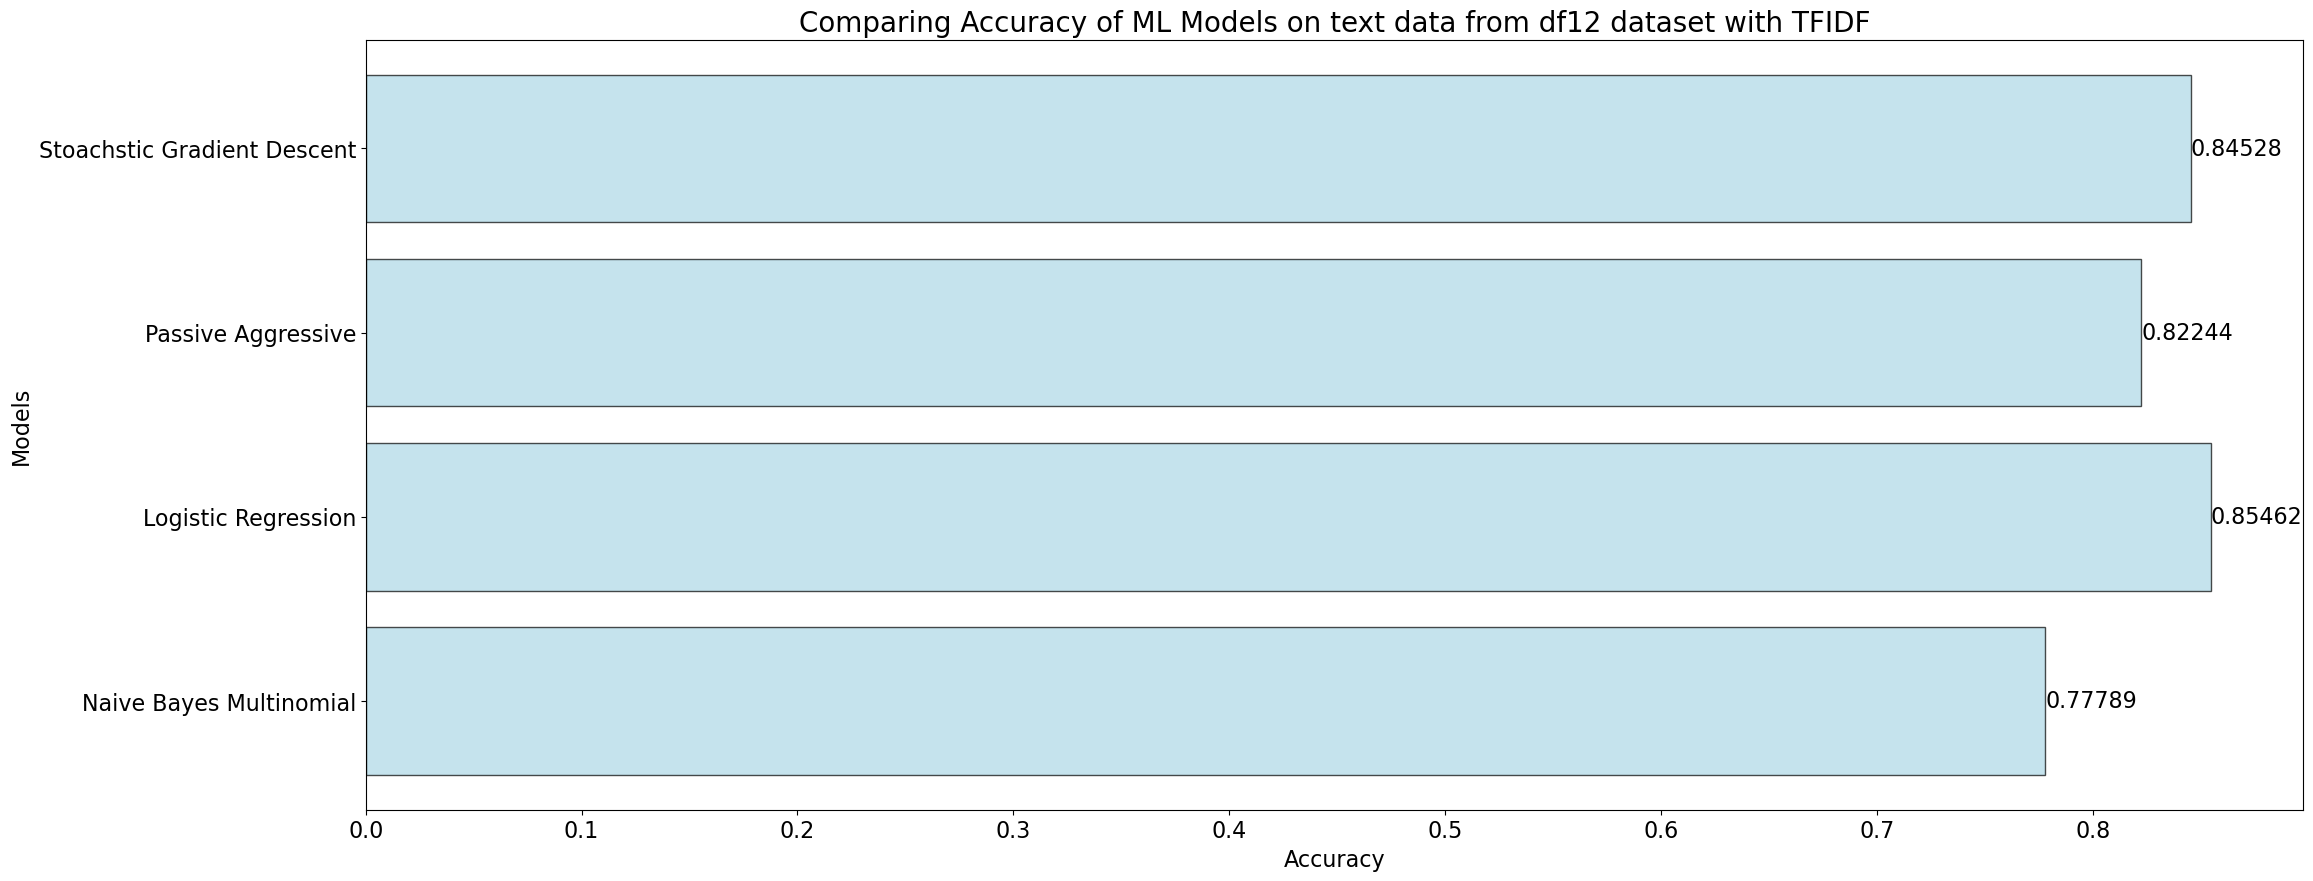

In [165]:
# Data for the chart
acc_labels_sel = list(acc_labels_df12_tfidf_sel.keys())
acc_values_sel = list(acc_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset with TFIDF', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_sel, acc_values_sel, color='lightblue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 2: f1-score of all four models TF-IDF

In [166]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_tfidf_sel={'Naive Bayes Multinomial':f1_NB_Mult_df12_tfidf,
        'Logistic Regression':f1_LogReg_df12_tfidf,
        'Passive Aggressive':f1_PassAgg_df12_tfidf,
        'Stoachstic Gradient Descent':f1_sgd_df12_tfidf} 
        

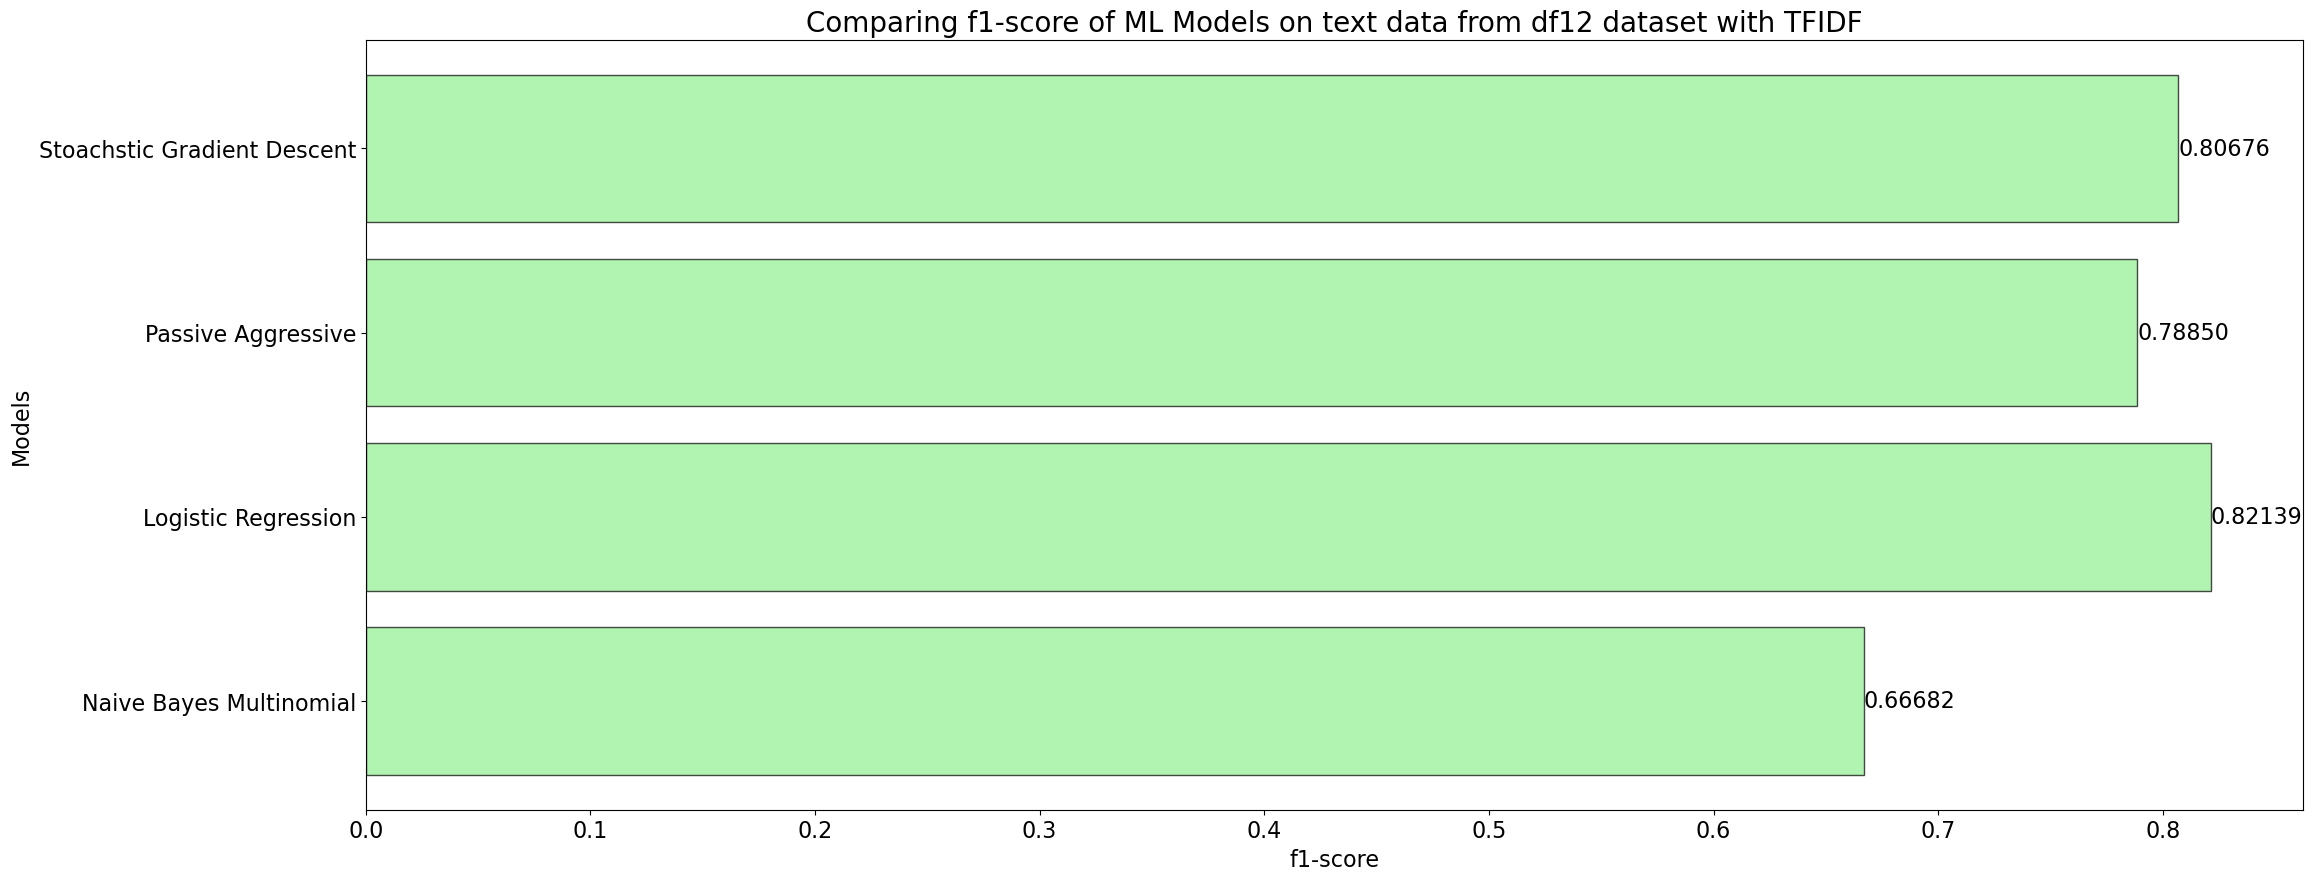

In [167]:
# Data for the chart
f1_labels_sel = list(f1_labels_df12_tfidf_sel.keys())
f1_values_sel = list(f1_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset with TFIDF', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_sel, f1_values_sel, color='lightgreen', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 3: confusion matrix of all four models TF-IDF

### NAIVE BAYES MULTINOMIAL

In [168]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_tfidf, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,14041,652
1.0,4961,5617


In [169]:
# create confusion matrix
cf_matrix_NB_Mult_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
print(cf_matrix_NB_Mult_df12_tfidf)


[[14041   652]
 [ 4961  5617]]


Confusion Matrix for Naive Bayes Multinomial TFIDF


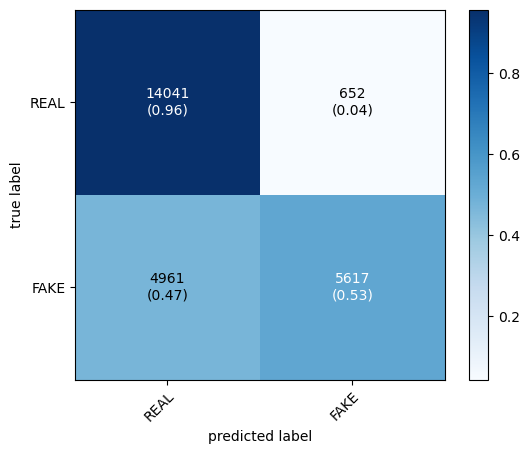

In [170]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Naive Bayes Multinomial TFIDF")
plot_confusion_matrix(conf_mat = cf_matrix_NB_Mult_df12_tfidf,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();


### LOGISTIC REGRESSION

In [171]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,13149,1544
1.0,2130,8448


In [172]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf)
print(cf_matrix_LogReg_df12_tfidf)


[[13149  1544]
 [ 2130  8448]]


Confusion Matrix for Logistic Regression TFIDF


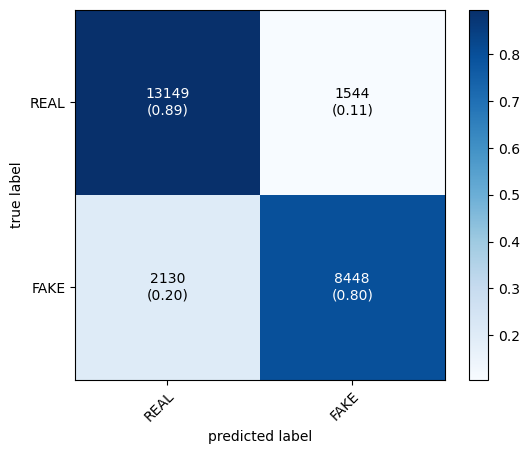

In [173]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Logistic Regression TFIDF")
plot_confusion_matrix(conf_mat = cf_matrix_LogReg_df12_tfidf,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();


### PASSIVE AGGRESSIVE 

In [174]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf, rownames=["real"], colnames=["predict"])

predict,0.0,1.0
real,,
0.0,12420,2273
1.0,2214,8364


In [175]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf)
print(cf_matrix_PassAgg_df12_tfidf)

[[12420  2273]
 [ 2214  8364]]


Confusion Matrix for Passive Aggressive TFIDF


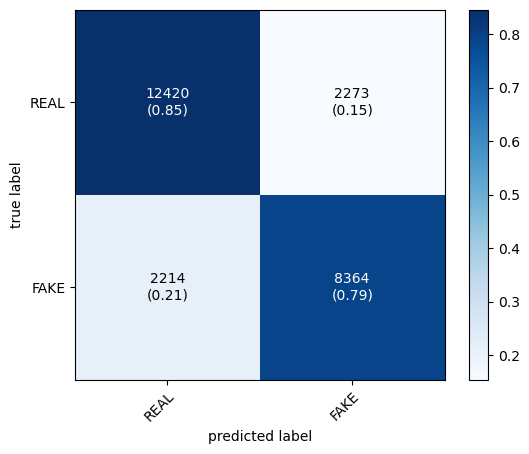

In [176]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Passive Aggressive TFIDF")
plot_confusion_matrix(conf_mat = cf_matrix_PassAgg_df12_tfidf,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();


### STOCHASTIC GRADIENT DESCENT 

In [177]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf, rownames=["real"], colnames=["predict"])

predict,0.0,1.0
real,,
0.0,13199,1494
1.0,2416,8162


In [178]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf)
print(cf_matrix_sgd_df12_tfidf)

[[13199  1494]
 [ 2416  8162]]


Confusion Matrix for Stochastic Gradient Descent TFIDF


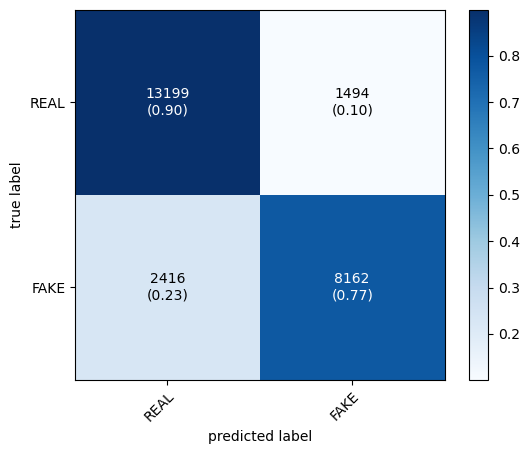

In [179]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Stochastic Gradient Descent TFIDF")
plot_confusion_matrix(conf_mat = cf_matrix_sgd_df12_tfidf,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();


# STACKING TF-IDF MODELS + CROSS-VALIDATE

In [181]:
from sklearn.ensemble import StackingClassifier


In [ ]:
## We stack the 4 best models
# Naive Bayes Multinomial
# Logistic Regression
# Passive Aggressive Classifier
# Stochastic Gradient Descent


In [194]:
# Create a new feature matrix with the predictions
stacked_features_tfidf_4 = np.column_stack((y_pred_NB_Mult_df12_tfidf, y_pred_LogReg_df12_tfidf, 
                                            y_pred_PassAgg_df12_tfidf, y_pred_sgd_df12_tfidf))


In [213]:
# Train the meta model (Logistic Regression in this case) on the new feature matrix
meta_model_tfidf_4 = clf_LogReg_df12_tfidf
meta_model_tfidf_4.fit(stacked_features_tfidf_4, Y_test_df12)


LogisticRegression(n_jobs=-1)

In [214]:
# Make final predictions using the meta model
meta_preds_tfidf_4 = meta_model_tfidf_4.predict(stacked_features_tfidf_4)


In [215]:
# Evaluate the accuracy of the stacked model
accuracy_meta_tfidf_4 = accuracy_score(Y_test_df12, meta_preds_tfidf_4)
print("Stacked model accuracy:", accuracy_meta_tfidf_4)

# 0.855

Stacked model accuracy: 0.8552886708084365


In [216]:
# Evaluate the f1 score of the stacked model
f1_meta_tfidf_4 = f1_score(Y_test_df12, meta_preds_tfidf_4)
print("Stacked model f1 score:", f1_meta_tfidf_4)

# 0.822

Stacked model f1 score: 0.8228798372644938


In [217]:
# get confusion matrix
pd.crosstab(Y_test_df12, meta_preds_tfidf_4, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,13119,1574
1.0,2083,8495


In [218]:
from sklearn.metrics import classification_report 

# get classification report
print("Stacking classification report:\n ", classification_report (Y_test_df12, meta_preds_tfidf_4))


Stacking classification report:
                precision    recall  f1-score   support

         0.0       0.86      0.89      0.88     14693
         1.0       0.84      0.80      0.82     10578

    accuracy                           0.86     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.85      0.86      0.85     25271



In [219]:
# create confusion matrix
cf_matrix_meta_tfidf_4 = confusion_matrix(Y_test_df12, meta_preds_tfidf_4)
print(cf_matrix_meta_tfidf_4)


[[13119  1574]
 [ 2083  8495]]


Confusion Matrix for Stacking model TFIDF


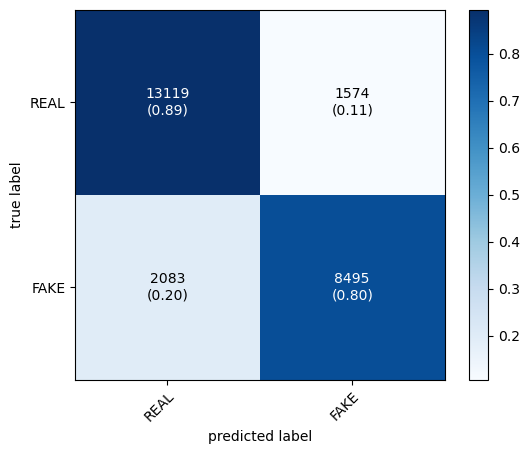

In [393]:
from mlxtend.plotting import plot_confusion_matrix

print("Confusion Matrix for Stacking model TFIDF")
plot_confusion_matrix(conf_mat = cf_matrix_meta_tfidf_4,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.show();

# CROSS VALIDATION

In [220]:
from sklearn.model_selection import cross_validate, KFold

In [221]:
cv3 = KFold(n_splits=3, shuffle=True)

In [233]:
sclf_tfidf_4 = StackingClassifier([("NB", clf_mult_df12_tfidf), ("lr", clf_LogReg_df12_tfidf), ("pac", pac_df12_tfidf), 
                                ("sgd", sgd_df12_tfidf)], final_estimator=clf_LogReg_df12_tfidf)


In [237]:
for clf, label in zip([clf_mult_df12_tfidf, clf_LogReg_df12_tfidf, pac_df12_tfidf, sgd_df12_tfidf, sclf_tfidf_4], ["Naive Bayes Multinomial", "Logistic Regression", "Passive Aggressive Classifier", "Stochastic Gradient Descent", "Stacking Classifier"]):
    scores = cross_validate(clf, X_train_text_df12_tfidf, Y_train_df12, cv=cv3, scoring=["accuracy", "f1"])
    print(label, "accuracy: ", scores["test_accuracy"].mean(), scores["test_accuracy"].std(), "f1: ", scores["test_f1"].mean(), scores["test_f1"].std())
    

Naive Bayes Multinomial accuracy:  0.7544715303432149 0.0009529510709506239 f1:  0.608587684464237 0.004025398290768578
Logistic Regression accuracy:  0.8502136616194728 0.0016096326875761054 f1:  0.8159953963912869 0.0016833363213143283
Passive Aggressive Classifier accuracy:  0.8173993948762709 0.0008333379779116304 f1:  0.7838145877061842 0.002135978013283802
Stochastic Gradient Descent accuracy:  0.8441791277055651 0.002089318880543675 f1:  0.8058509910032164 0.0023146883789911953
Stacking Classifier accuracy:  0.8499366957840838 0.0016586997933607454 f1:  0.8171696222519133 0.001826482806985051


# Vectorizing: COUNT VECTORIZER 

### COUNT VECTORIZER 
### USING CONTENT_CLEANED AND TITLE ONLY


In [86]:
# VECTORIZING
# TAKES 1 MINUTE
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, csr_matrix

# Initialize vectorizer, using the CountVectorizer method. The goal here is to extract only the words
vectorizer1_df12_count = CountVectorizer(ngram_range = (2,2))
vectorizer2_df12_count = CountVectorizer(ngram_range = (2,2))

vectorizer1_df12_count.fit(X_train_df12['content_cleaned'])
vectorizer2_df12_count.fit(X_train_df12['title'])


CountVectorizer(ngram_range=(2, 2))

In [87]:
# TAKES 1 MINUTE

X_train_content_df12_count= vectorizer1_df12_count.transform(X_train_df12['content_cleaned'])
X_train_title_df12_count = vectorizer2_df12_count.transform(X_train_df12['title'])
X_test_content_df12_count = vectorizer1_df12_count.transform(X_test_df12['content_cleaned'])
X_test_title_df12_count = vectorizer2_df12_count.transform(X_test_df12['title'])


In [88]:
X_train_text_df12_count = hstack([X_train_content_df12_count, X_train_title_df12_count])
X_test_text_df12_count = hstack([X_test_content_df12_count, X_test_title_df12_count])


In [89]:
X_train_text_df12_count

<101084x12152906 sparse matrix of type '<class 'numpy.int64'>'
	with 29781372 stored elements in Compressed Sparse Row format>

In [90]:
X_train_text_df12_count.shape

(101084, 12152906)

In [91]:
X_test_text_df12_count

<25271x12152906 sparse matrix of type '<class 'numpy.int64'>'
	with 5223825 stored elements in Compressed Sparse Row format>

In [92]:
X_test_text_df12_count.shape

(25271, 12152906)

In [93]:
Y_train_df12

22684     0.0
65415     1.0
113795    0.0
73055     0.0
71554     1.0
         ... 
92007     0.0
96663     0.0
90426     1.0
11148     0.0
66170     1.0
Name: label, Length: 101084, dtype: float64

In [94]:
Y_train_df12

22684     0.0
65415     1.0
113795    0.0
73055     0.0
71554     1.0
         ... 
92007     0.0
96663     0.0
90426     1.0
11148     0.0
66170     1.0
Name: label, Length: 101084, dtype: float64

In [ ]:
## MODELS FOR STAGE 3 (Optimized Models) - Chosen Models for final stage:

# 4) Logistic Regression
# (5) Random Forest)

# 6) Passive Aggressive Classifier 
# 7) Stochastic Gradient Descent (SGD)


# CREATE MODELS WITH COUNT VECTORIZER AS IN STAGE 2


# 2 MULTINOMIAL NAIVE BAYES on text data df12 count


In [238]:
from sklearn.naive_bayes import MultinomialNB

In [239]:
from sklearn.naive_bayes import MultinomialNB
clf_mult_df12_count = MultinomialNB()


In [248]:
# fit the model
clf_mult_df12_count.fit(X_train_text_df12_count, Y_train_df12)


MultinomialNB()

In [249]:
y_pred_NB_Mult_df12_count= clf_mult_df12_count.predict(X_test_text_df12_count)


In [250]:
# get accuracy
accuracy_NB_Mult_df12_count = clf_mult_df12_count.score(X_test_text_df12_count, Y_test_df12)
accuracy_NB_Mult_df12_count

# 0.83


0.8351470064500811

In [251]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Mult_df12_count = f1_score(Y_test_df12, y_pred_NB_Mult_df12_count)
f1_NB_Mult_df12_count

# 0.778
# improvement compared to tf-idf

0.778357097254735

In [252]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_count, rownames=["real"], colnames=["predict"])

# overall prediction is ok
# best prediction: upper right corner (false positives)

predict,0.0,1.0
real,,
0.0,13790,903
1.0,3263,7315


In [253]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Multinomial df12 count vectorizer classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Mult_df12_count))

Naive Bayes Multinomial df12 count vectorizer classification report:
                precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     14693
         1.0       0.89      0.69      0.78     10578

    accuracy                           0.84     25271
   macro avg       0.85      0.82      0.82     25271
weighted avg       0.84      0.84      0.83     25271



In [254]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [255]:
# create confusion matrix
cf_matrix_NB_Mult_df12_count = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_count)
print(cf_matrix_NB_Mult_df12_count)


[[13790   903]
 [ 3263  7315]]


In [ ]:
# INTERPRETATION

In [317]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import lime
import lime.lime_text
import shap


In [ ]:
### LIME

In [ ]:
'''
# LIME interpretation
explainer = lime.lime_text.LimeTextExplainer()
def predict_fn(texts):
    vectors = hstack([vectorizer1_df12_count.transform(texts[:, 0]), vectorizer2_df12_count.transform(texts[:, 1])])
    return clf_mult_df12_count.predict_proba(vectors)

# Select a sample text for interpretation
sample_text = np.array([[X_train_df12['content_cleaned'][0], X_train_df12['title'][0]]])
exp = explainer.explain_instance(sample_text[0], predict_fn, num_features=10)
exp.show_in_notebook(text=sample_text[0])
'''

# errors


In [ ]:
### SHAP

In [ ]:
'''
import shap

# Create a single vectorizer for content and title
vectorizer_combined = TfidfVectorizer(ngram_range=(2, 2))
X_train_combined = vectorizer_combined.fit_transform(X_train_df12['content_cleaned'] + ' ' + X_train_df12['title'])

# SHAP interpretation
explainer_shap = shap.Explainer(clf_mult_df12_count, vectorizer_combined.transform)
shap_values = explainer_shap(vectorizer_combined.transform(X_train_df12['content_cleaned'] + ' ' + X_train_df12['title']))
shap.summary_plot(shap_values, vectorizer_combined.get_feature_names())
'''

## error

# 4 LOGISTIC REGRESSION MODEL ON TEXT DATA df12


In [259]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_count = LogisticRegression(C=1.0, n_jobs=-1)


In [260]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_count.fit(X_train_text_df12_count, Y_train_df12)


LogisticRegression(n_jobs=-1)

In [261]:
y_pred_LogReg_df12_count = clf_LogReg_df12_count.predict(X_test_text_df12_count)


In [262]:
# get accuracy
accuracy_LogReg_df12_count = clf_LogReg_df12_count.score(X_test_text_df12_count, Y_test_df12)
accuracy_LogReg_df12_count

# 0.853
# no change compared to tf-idf


0.8536662577658185

In [263]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_count = f1_score(Y_test_df12, y_pred_LogReg_df12_count)
f1_LogReg_df12_count

# 0.823
# no change compared to tf-idf

0.823854434600362

In [264]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_count, rownames=["real"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)

predict,0.0,1.0
real,,
0.0,12925,1768
1.0,1930,8648


In [265]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 count vectorizer classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_count))


Logistic Regression df12 count vectorizer classification report:
                precision    recall  f1-score   support

         0.0       0.87      0.88      0.87     14693
         1.0       0.83      0.82      0.82     10578

    accuracy                           0.85     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.85      0.85      0.85     25271



In [266]:
# create confusion matrix
cf_matrix_LogReg_df12_count = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_count)
print(cf_matrix_LogReg_df12_count)


[[12925  1768]
 [ 1930  8648]]


# 6 Passive Aggressive Classifier on text data df12


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [103]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [104]:
# Initialize a PassiveAggressiveClassifier
pac_df12_count = PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)


In [105]:
# fit model
pac_df12_count.fit(X_train_text_df12_count, Y_train_df12)


PassiveAggressiveClassifier(max_iter=50, n_jobs=-1)

In [106]:
#Predict on the test set 
y_pred_PassAgg_df12_count = pac_df12_count.predict(X_test_text_df12_count)


In [107]:
# get accuracy
accuracy_PassAgg_df12_count= pac_df12_count.score(X_test_text_df12_count, Y_test_df12)
accuracy_PassAgg_df12_count

# 0.842
# improved compared to TF-IDF


0.8421115112183927

In [109]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_count = f1_score(Y_test_df12, y_pred_PassAgg_df12_count)
f1_PassAgg_df12_count

# 0.812
# improved compared to TF-IDF


0.81216457960644

In [110]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_count, rownames=["real"], colnames=["predict"])

# overall prediction is quite good but no very good prediction for any case

predict,0.0,1.0
real,,
0.0,12655,2038
1.0,1952,8626


In [111]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 count vectorizer classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_count))


Passive Aggressive df12 count vectorizer classification report:
                precision    recall  f1-score   support

         0.0       0.87      0.86      0.86     14693
         1.0       0.81      0.82      0.81     10578

    accuracy                           0.84     25271
   macro avg       0.84      0.84      0.84     25271
weighted avg       0.84      0.84      0.84     25271



In [112]:
# create confusion matrix
cf_matrix_PassAgg_df12_count = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_count)
print(cf_matrix_PassAgg_df12_count)


[[12655  2038]
 [ 1952  8626]]


# 10 Stochastic Gradient Decent (SGD) on text data df12

In [113]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_count = SGDClassifier(n_jobs=-1)

In [114]:
# Train the SGD model
sgd_df12_count.fit(X_train_text_df12_count, Y_train_df12)


SGDClassifier(n_jobs=-1)

In [115]:
# Make predictions on the test set
y_pred_sgd_df12_count = sgd_df12_count.predict(X_test_text_df12_count)


In [116]:
# Calculate accuracy
accuracy_sgd_df12_count = accuracy_score(Y_test_df12, y_pred_sgd_df12_count)
accuracy_sgd_df12_count

# 0.849
# slight improvement compared to tf-idf


0.8496300106841834

In [117]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_count = f1_score(Y_test_df12, y_pred_sgd_df12_count)
f1_sgd_df12_count

# 0.822
# slight improvement compared to tf-idf


0.8223635003739715

In [118]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_count, rownames=["real"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
real,,
0.0,12675,2018
1.0,1782,8796


In [119]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 count vectorizer classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_count))


SGD df12 count vectorizer classification report:
                precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     14693
         1.0       0.81      0.83      0.82     10578

    accuracy                           0.85     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.85      0.85      0.85     25271



In [120]:
# create confusion matrix
cf_matrix_sgd_df12_count = confusion_matrix(Y_test_df12, y_pred_sgd_df12_count)
print(cf_matrix_sgd_df12_count)

[[12675  2018]
 [ 1782  8796]]


# COMPARE MODELS ON TEXT DATA ONLY df12  Count Vectorizer


In [ ]:
# MODELS FOR STAGE 3 (Optimized Models):
# 2) Naive Bayes Multinomial
# 4) Logistic Regression
# 6) Passive Aggressive Classifier 
# 10) Stochastic Gradient Descent


In [268]:
print("Naive Bayes Multinomial accuracy score df12 count:", accuracy_NB_Mult_df12_count)
print("Logistic Regression accuracy score df12 count:", accuracy_LogReg_df12_count)
print("Passive Agressive accuracy score df12 count:", accuracy_PassAgg_df12_count)
print("Stochastic Gradient Descent accuracy score df12 count:", accuracy_sgd_df12_count)


Naive Bayes Multinomial accuracy score df12 count: 0.8351470064500811
Logistic Regression accuracy score df12 count: 0.8536662577658185
Passive Agressive accuracy score df12 count: 0.8421115112183927
Stochastic Gradient Descent accuracy score df12 count: 0.8496300106841834


In [270]:
print("Naive Bayes Multinomial f1 score df12 count:", f1_NB_Mult_df12_count)
print("Logistic Regression f1 score df12 count:", f1_LogReg_df12_count)
print("Passive Agressive f1 score df12 count:", f1_PassAgg_df12_count)
print("Stochastic Gradient Descent f1 score df12 count:", f1_sgd_df12_count)


Naive Bayes Multinomial f1 score df12 count: 0.778357097254735
Logistic Regression f1 score df12 count: 0.823854434600362
Passive Agressive f1 score df12 count: 0.81216457960644
Stochastic Gradient Descent f1 score df12 count: 0.8223635003739715


## PLOT 1: Accuracy of all four models Count Vectorizer

In [271]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_count_sel={'Naive Bayes Multinomial':accuracy_NB_Mult_df12_count,
        'Logistic Regression':accuracy_LogReg_df12_count,
        'Passive Aggressive':accuracy_PassAgg_df12_count,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_count} 
        

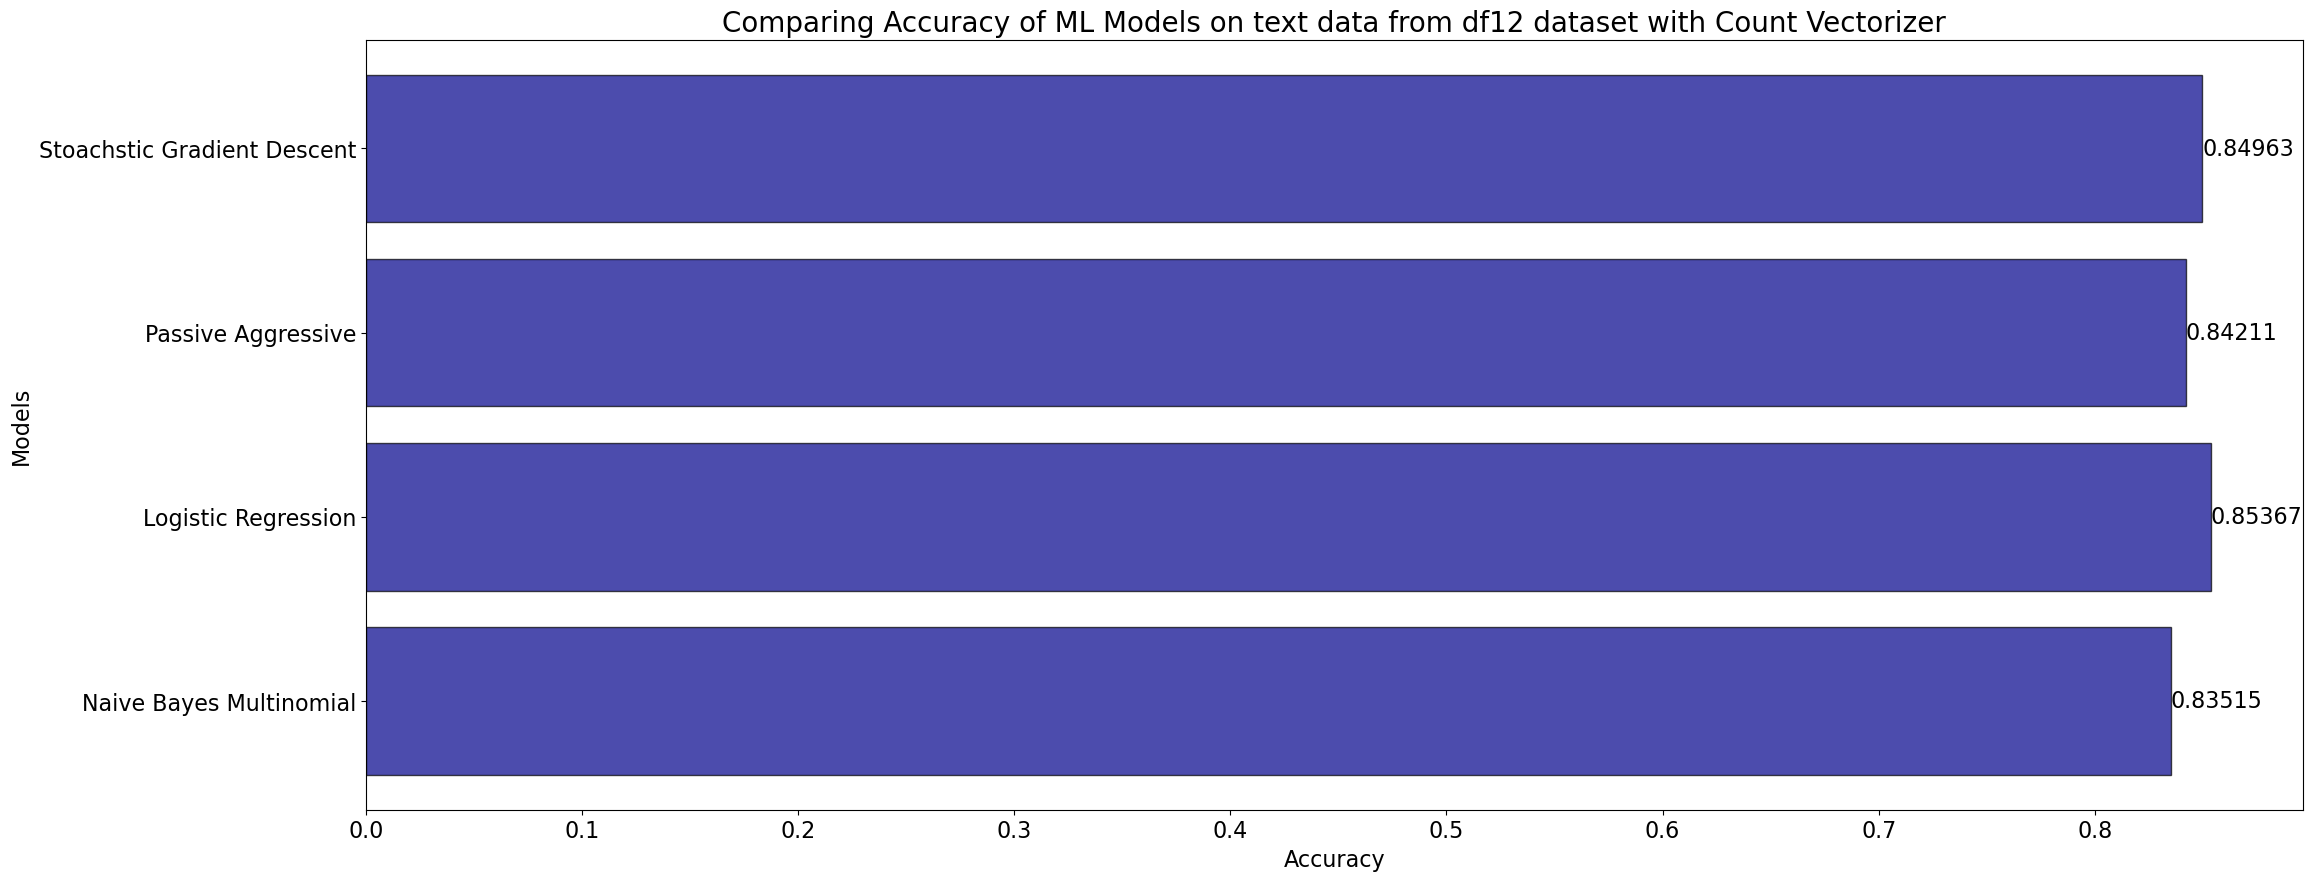

In [272]:
# Data for the chart
acc_labels_sel_count = list(acc_labels_df12_count_sel.keys())
acc_values_sel_count = list(acc_labels_df12_count_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset with Count Vectorizer', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_sel_count, acc_values_sel_count, color='darkblue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_sel_count):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 2: f1-score of all four models Count Vectorizer

In [273]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_count_sel={'Naive Bayes Multinomial':f1_NB_Mult_df12_count,
        'Logistic Regression':f1_LogReg_df12_count,
        'Passive Aggressive':f1_PassAgg_df12_count,
        'Stoachstic Gradient Descent':f1_sgd_df12_count} 
        

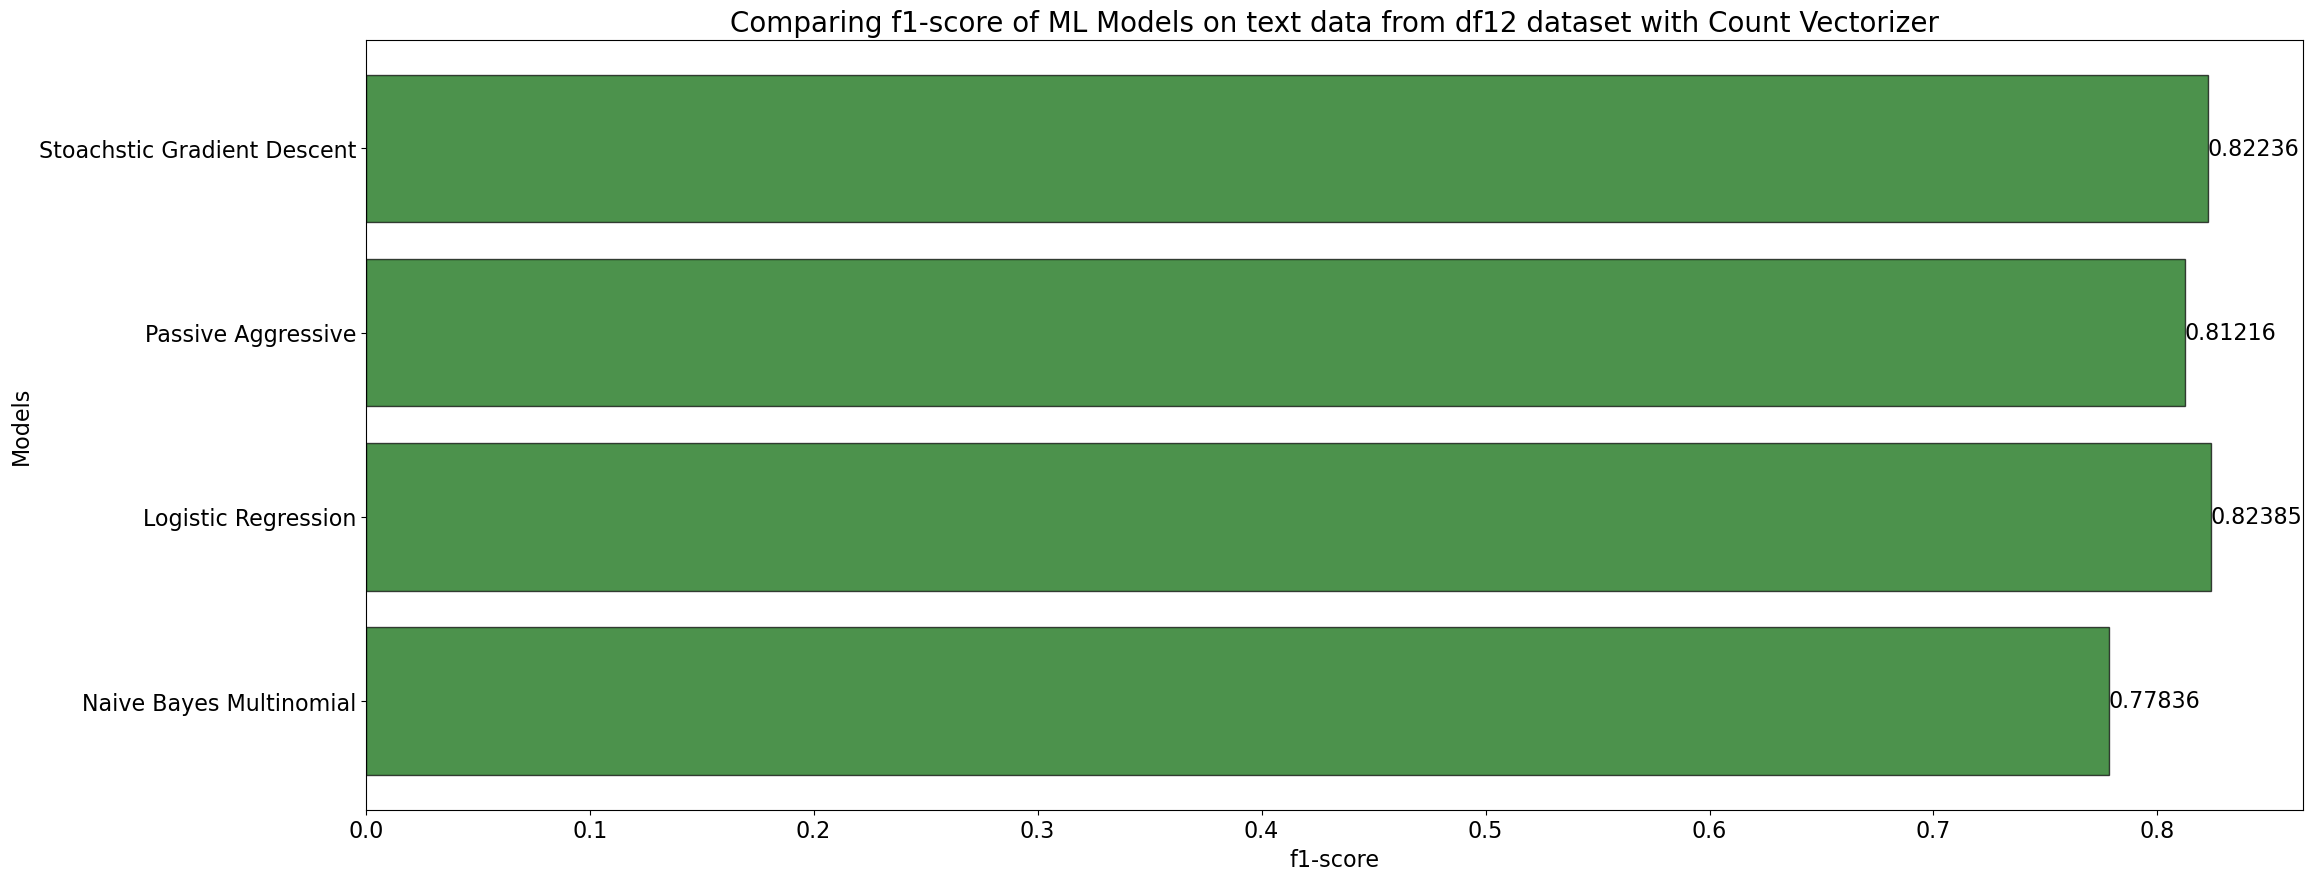

In [274]:
# Data for the chart
f1_labels_sel_count = list(f1_labels_df12_count_sel.keys())
f1_values_sel_count = list(f1_labels_df12_count_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset with Count Vectorizer', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_sel_count, f1_values_sel_count, color='darkgreen', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_sel_count):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

# PLOT 3: confusion matrix of all four models Count Vectorizer

### NAIVE BAYES MULTINOMIAL

In [275]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_count, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,13790,903
1.0,3263,7315


In [276]:
# create confusion matrix
cf_matrix_NB_Mult_df12_count = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_count)
print(cf_matrix_NB_Mult_df12_count)


[[13790   903]
 [ 3263  7315]]


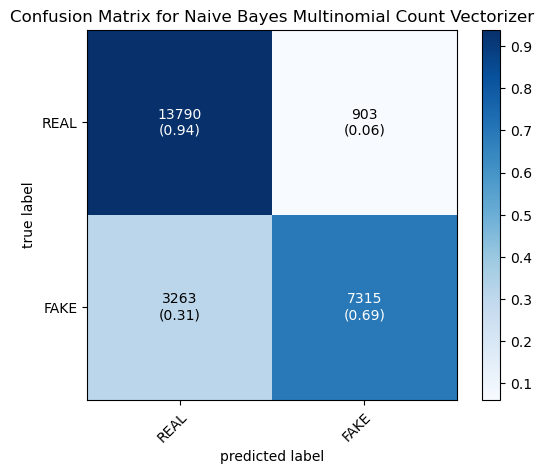

In [328]:
from mlxtend.plotting import plot_confusion_matrix

# print("Confusion Matrix for Naive Bayes Multinomial Count Vectorizer")
plot_confusion_matrix(conf_mat = cf_matrix_NB_Mult_df12_count,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.title("Confusion Matrix for Naive Bayes Multinomial Count Vectorizer")
plt.show();


### LOGISTIC REGRESSION

In [279]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_count, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,12925,1768
1.0,1930,8648


In [280]:
# create confusion matrix
cf_matrix_LogReg_df12_count = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_count)
print(cf_matrix_LogReg_df12_count)


[[12925  1768]
 [ 1930  8648]]


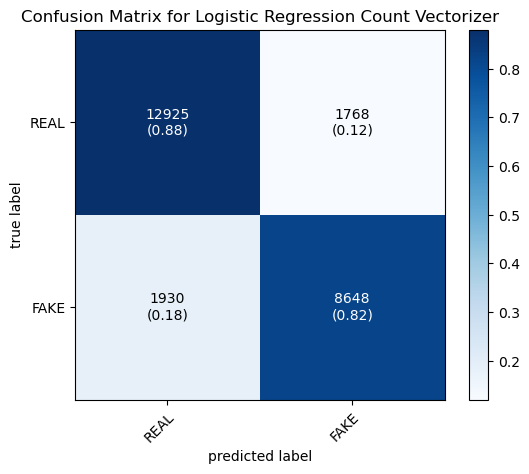

In [329]:
from mlxtend.plotting import plot_confusion_matrix

# print("Confusion Matrix for Logistic Regression Count Vectorizer")
plot_confusion_matrix(conf_mat = cf_matrix_LogReg_df12_count,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.title("Confusion Matrix for Logistic Regression Count Vectorizer")
plt.show();



### PASSIVE AGGRESSIVE 

In [282]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_count, rownames=["real"], colnames=["predict"])

predict,0.0,1.0
real,,
0.0,12655,2038
1.0,1952,8626


In [283]:
# create confusion matrix
cf_matrix_PassAgg_df12_count = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_count)
print(cf_matrix_PassAgg_df12_count)

[[12655  2038]
 [ 1952  8626]]


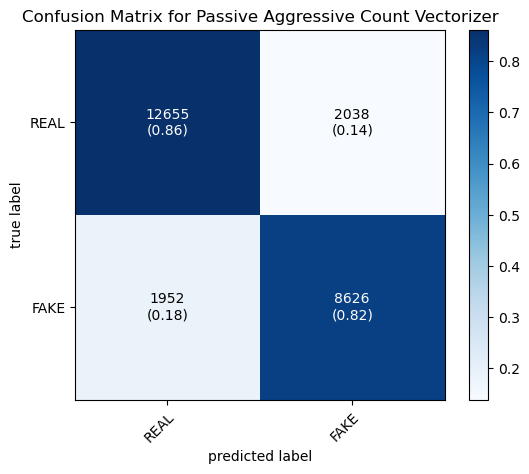

In [330]:
from mlxtend.plotting import plot_confusion_matrix

# print("Confusion Matrix for Passive Aggressive Count Vectorizer")
plot_confusion_matrix(conf_mat = cf_matrix_PassAgg_df12_count,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.title("Confusion Matrix for Passive Aggressive Count Vectorizer")
plt.show();


### STOCHASTIC GRADIENT DESCENT 

In [285]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_count, rownames=["real"], colnames=["predict"])

predict,0.0,1.0
real,,
0.0,12675,2018
1.0,1782,8796


In [286]:
# create confusion matrix
cf_matrix_sgd_df12_count = confusion_matrix(Y_test_df12, y_pred_sgd_df12_count)
print(cf_matrix_sgd_df12_count)

[[12675  2018]
 [ 1782  8796]]


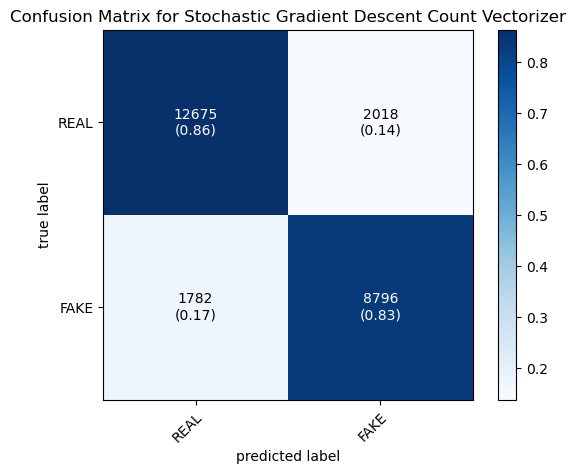

In [331]:
from mlxtend.plotting import plot_confusion_matrix

# print("Confusion Matrix for Stochastic Gradient Descent Count Vectorizer")
plot_confusion_matrix(conf_mat = cf_matrix_sgd_df12_count,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.title("Confusion Matrix for Stochastic Gradient Descent Count Vectorizer")
plt.show();


# STACKING COUNTVECTORIZER MODELS + CROSS-VALIDATE

In [288]:
from sklearn.ensemble import StackingClassifier


In [ ]:
## We stack the 4 best models
# Naive Bayes Multinomial
# Logistic Regression
# Passive Aggressive Classifier
# Stochastic Gradient Descent


In [295]:
# Create a new feature matrix with the predictions
stacked_features_count_4 = np.column_stack((y_pred_NB_Mult_df12_count, y_pred_LogReg_df12_count, 
                                            y_pred_PassAgg_df12_count, y_pred_sgd_df12_count))


In [296]:
# Train the meta model (Logistic Regression in this case) on the new feature matrix
meta_model_count_4 = clf_LogReg_df12_tfidf
meta_model_count_4.fit(stacked_features_count_4, Y_test_df12)


LogisticRegression(n_jobs=-1)

In [297]:
# Make final predictions using the meta model
meta_preds_count_4 = meta_model_count_4.predict(stacked_features_count_4)


In [298]:
# Evaluate the accuracy of the stacked model
accuracy_meta_count_4 = accuracy_score(Y_test_df12, meta_preds_count_4)
print("Stacked model accuracy:", accuracy_meta_count_4)

# 0.857

Stacked model accuracy: 0.8570693680503344


In [299]:
# Evaluate the f1 score of the stacked model
f1_meta_count_4 = f1_score(Y_test_df12, meta_preds_count_4)
print("Stacked model f1 score:", f1_meta_count_4)

# 0.826

Stacked model f1 score: 0.8262793382070026


In [300]:
# get confusion matrix
pd.crosstab(Y_test_df12, meta_preds_count_4, rownames=["real"], colnames=["predict"])


predict,0.0,1.0
real,,
0.0,13069,1624
1.0,1988,8590


In [301]:
from sklearn.metrics import classification_report 

# get classification report
print("Stacking classification report:\n ", classification_report (Y_test_df12, meta_preds_count_4))


Stacking classification report:
                precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     14693
         1.0       0.84      0.81      0.83     10578

    accuracy                           0.86     25271
   macro avg       0.85      0.85      0.85     25271
weighted avg       0.86      0.86      0.86     25271



In [302]:
# create confusion matrix
cf_matrix_meta_count_4 = confusion_matrix(Y_test_df12, meta_preds_count_4)
print(cf_matrix_meta_count_4)


[[13069  1624]
 [ 1988  8590]]


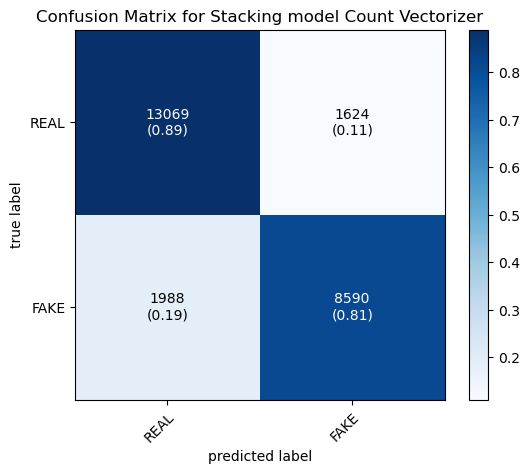

In [353]:
from mlxtend.plotting import plot_confusion_matrix

# print("Confusion Matrix for Stochastic Gradient Descent Count Vectorizer")
plot_confusion_matrix(conf_mat = cf_matrix_meta_count_4,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True,
                      class_names=['REAL','FAKE'])
plt.title("Confusion Matrix for Stacking model Count Vectorizer")
plt.show();


# CROSS VALIDATION
# takes 1 hour


In [323]:
from sklearn.model_selection import cross_validate, KFold

In [324]:
cv3 = KFold(n_splits=3, shuffle=True)

In [325]:
sclf_count_4 = StackingClassifier([("NB", clf_mult_df12_count), ("lr", clf_LogReg_df12_count), ("pac", pac_df12_count), 
                                ("sgd", sgd_df12_count)], final_estimator=clf_LogReg_df12_count)


In [326]:
for clf, label in zip([clf_mult_df12_count, clf_LogReg_df12_count, pac_df12_count, sgd_df12_count, sclf_count_4], ["Naive Bayes Multinomial", "Logistic Regression", "Passive Aggressive Classifier", "Stochastic Gradient Descent", "Stacking Classifier"]):
    scores = cross_validate(clf, X_train_text_df12_count, Y_train_df12, cv=cv3, scoring=["accuracy", "f1"])
    print(label, "accuracy: ", scores["test_accuracy"].mean(), scores["test_accuracy"].std(), "f1: ", scores["test_f1"].mean(), scores["test_f1"].std())
    

Naive Bayes Multinomial accuracy:  0.8325056689850717 0.0028643450120715195 f1:  0.79349596145086 0.0035760369844448623
Logistic Regression accuracy:  0.8448814657869576 0.001823759422963097 f1:  0.8133936148031435 0.0023300540346867606
Passive Aggressive Classifier accuracy:  0.833969794207591 0.002267676588384451 f1:  0.8025937033055968 0.002478760156211542
Stochastic Gradient Descent accuracy:  0.8414091111558308 0.0015495049168915748 f1:  0.8108972580023094 0.0015246244423368896
Stacking Classifier accuracy:  0.8545170356020746 0.00023098250718917463 f1:  0.8239200317970664 0.0007127779725527534
